In [2]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [3]:
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
from caption_featurizers import CaptionFeaturizer
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import CaptionEncoder

import time
import math

In [34]:
from scipy import stats

In [4]:
import color_featurizers

In [157]:
importlib.reload(color_featurizers)

<module 'color_featurizers' from '/Users/benjaminnewman/Documents/Stanford/Freshman_2017-2018/WINTER/LINGUIST130A/linguist-130a-final-proj/color_featurizers.py'>

In [3]:
class MonroeExperiment:
    
    def __init__(self, train_data, test_data, featurizers, model, optimizer=torch.optim.Adadelta,
                 criterion=nn.NLLLoss, lr=0.2, num_epochs=50):
        self.train_data = train_data
        self.test_data = test_data
        self.caption_featurizer = featurizers['caption']
        self.color_featurizer = featurizers['color']
        self.model = model
        
        self.optimizer = optimizer
        self.criterion = criterion
        
        # misc args:
        self.lr = 0.2
        self.num_epochs = num_epochs
        
        # for reproducibility, store training pairs
        self.train_pairs = None
    
    def train_iter(self, caption_tensor, color_tensor, target, optimizer, criterion):
        start_states = self.model.init_hidden_and_context()
        input_length = caption_tensor.size(0)
        optimizer.zero_grad()
        loss = 0

        model_output, _, _ = self.model(caption_tensor, start_states, color_tensor)
        model_output = model_output.view(1, -1)

        loss += criterion(model_output, target)
        loss.backward()
        optimizer.step()

        return loss
    
    def get_pairs(self, data, construct=False):
        # create pairs (caption, colors, target)
        pairs = []
        for entry in data:
            caption_features = self.caption_featurizer.to_tensor(entry.caption, construct=construct)
            color_features = self.color_featurizer.to_tensor(entry.colors)
            color_features, target = self.color_featurizer.shuffle_colors(color_features)
            
            pairs.append((caption_features, color_features, target))
        
        return pairs
            
    # from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)  
    
    
    def init_model(self, **model_params):
        self.caption_featurizer.construct_featurizer(self.train_data)
        self.train_pairs = self.get_pairs(self.train_data, construct=True)
        model_params['vocab_size'] = self.caption_featurizer.caption_indexer.size
        self.model = self.model(**model_params)
            
    def train_model(self):
        # training pairs should have already been created by calling init model
        

        optimizer = self.optimizer(lr=self.lr,params=self.model.parameters())
        criterion = self.criterion()
        
        start_time = time.time()
        store_losses_every = 100
        print_losses_every = 1000
        self.stored_losses = []
        for epoch in range(self.num_epochs):
            print("---EPOCH {}---".format(epoch))
            stored_loss_total = 0
            print_loss_total = 0

            for i, pair in enumerate(self.train_pairs):
                caption, colors, target = pair
                # print(target)

                loss = self.train_iter(caption, colors, target, optimizer, criterion)
                stored_loss_total += loss.item()
                print_loss_total += loss.item()

                if i % print_losses_every == 0:
                    print_loss_avg = print_loss_total / print_losses_every
                    print("{} ({}:{} {:.2f}%) {:.4f}".format(self.asMinutes(time.time() - start_time),
                                                      epoch, i, i/len(self.train_pairs)*100,
                                                      print_loss_avg))
                    print_loss_total = 0

                if i % store_losses_every == 0:
                    stored_loss_avg = stored_loss_total / store_losses_every
                    self.stored_losses.append(stored_loss_avg)
                    stored_loss_total = 0
                    
                    
    def evaluate_iter(self, pair):
        with torch.no_grad():
            caption_tensor, color_tensor, target = pair
            start_states = self.model.init_hidden_and_context()
            model_output, _, _ = self.model(caption_tensor, start_states, color_tensor)

            model_output = model_output.view(1, -1)
            if torch.argmax(model_output).item() == target.item():
                return 1, model_output
            else:
                return 0, model_output

              
    def evaluate_model(self):
        """
        Evaluate model accuracy
        """
        test_pairs = self.get_pairs(self.test_data)
        self.model.eval()
        
        total_correct = 0
        for pair in test_pairs:
            correct, _ = self.evaluate_iter(pair) 
            total_correct += correct
        
        accuracy = total_correct/len(self.test_data)
        print("Accuracy: {}".format(accuracy))
        return accuracy
    
    
    
    def evaluate_model_score(self):
        test_pairs = self.get_pairs(self.test_data)
        self.model.eval()
        
        test_scores = []
        for pair in test_pairs:
            correct, model_output = self.evaluate_iter(pair)
            # the score we care about is the amount of probability mass
            # on the target (let's say)
            pair_score = model_output[target.item()]
            test_scores.append(pair_score)
        
        

In [5]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [13]:
caption_phi = CaptionFeaturizer()
color_phi = ColorFeaturizer(color_phi_fourier, "rgb")

In [9]:
experiment_one = MonroeExperiment(train_data, dev_data, {'caption':caption_phi, 'color':color_phi}, CaptionEncoder)

In [10]:
experiment_one.init_model(embed_dim = 100, hidden_dim=100, color_dim=3, color_in_dim=3)

In [145]:
experiment_one.train_model()

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0030
0m 5s (0:1000 6.38%) 1.1018
0m 12s (0:2000 12.77%) 1.0692
0m 18s (0:3000 19.15%) 1.0644
0m 26s (0:4000 25.53%) 1.0571
0m 34s (0:5000 31.92%) 1.0703
0m 41s (0:6000 38.30%) 1.0665
0m 48s (0:7000 44.69%) 1.0629
0m 55s (0:8000 51.07%) 1.0790
1m 3s (0:9000 57.45%) 1.0433
1m 10s (0:10000 63.84%) 1.0727
1m 17s (0:11000 70.22%) 1.0300
1m 24s (0:12000 76.60%) 1.0613
1m 32s (0:13000 82.99%) 1.0486
1m 39s (0:14000 89.37%) 1.0364
1m 46s (0:15000 95.75%) 1.0535
---EPOCH 1---
1m 51s (1:0 0.00%) 0.0013
1m 58s (1:1000 6.38%) 1.0385
2m 6s (1:2000 12.77%) 1.0376
2m 13s (1:3000 19.15%) 1.0332
2m 21s (1:4000 25.53%) 1.0485
2m 28s (1:5000 31.92%) 1.0505
2m 35s (1:6000 38.30%) 1.0639
2m 42s (1:7000 44.69%) 1.0497
2m 49s (1:8000 51.07%) 1.0638
2m 56s (1:9000 57.45%) 1.0359
3m 3s (1:10000 63.84%) 1.0687
3m 10s (1:11000 70.22%) 1.0222
3m 17s (1:12000 76.60%) 1.0578
3m 24s (1:13000 82.99%) 1.0436
3m 31s (1:14000 89.37%) 1.0299
3m 38s (1:15000 95.75%) 1.0429
---EPOCH 2---
3

29m 50s (16:1000 6.38%) 0.8165
29m 57s (16:2000 12.77%) 0.7513
30m 5s (16:3000 19.15%) 0.7124
30m 12s (16:4000 25.53%) 0.7434
30m 19s (16:5000 31.92%) 0.7524
30m 27s (16:6000 38.30%) 0.7700
30m 34s (16:7000 44.69%) 0.8644
30m 41s (16:8000 51.07%) 0.8077
30m 48s (16:9000 57.45%) 0.8145
30m 55s (16:10000 63.84%) 0.8299
31m 1s (16:11000 70.22%) 0.8863
31m 8s (16:12000 76.60%) 0.9215
31m 15s (16:13000 82.99%) 0.8431
31m 22s (16:14000 89.37%) 0.8008
31m 30s (16:15000 95.75%) 0.7938
---EPOCH 17---
31m 35s (17:0 0.00%) 0.0002
31m 41s (17:1000 6.38%) 0.8146
31m 49s (17:2000 12.77%) 0.7305
31m 56s (17:3000 19.15%) 0.7029
32m 4s (17:4000 25.53%) 0.7357
32m 11s (17:5000 31.92%) 0.7278
32m 18s (17:6000 38.30%) 0.7596
32m 25s (17:7000 44.69%) 0.8764
32m 32s (17:8000 51.07%) 0.8166
32m 39s (17:9000 57.45%) 0.8041
32m 46s (17:10000 63.84%) 0.8458
32m 53s (17:11000 70.22%) 0.8743
33m 0s (17:12000 76.60%) 0.9072
33m 7s (17:13000 82.99%) 0.8330
33m 14s (17:14000 89.37%) 0.7967
33m 21s (17:15000 95.75%) 

In [146]:
experiment_one.evaluate_model()

Accuracy: 0.4278876834716018


0.4278876834716018

In [14]:
experiment_fourier = MonroeExperiment(train_data, dev_data, {'caption':caption_phi, 'color':color_phi}, CaptionEncoder)
experiment_fourier.init_model(embed_dim = 100, hidden_dim=100, color_dim=54)


In [194]:
experiment_fourier.train_model()

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0000
0m 9s (0:1000 6.38%) 1.2183
0m 21s (0:2000 12.77%) 0.9420
0m 34s (0:3000 19.15%) 0.9296
0m 47s (0:4000 25.53%) 0.8703
1m 0s (0:5000 31.92%) 0.9012
1m 12s (0:6000 38.30%) 0.6950
1m 24s (0:7000 44.69%) 0.6041
1m 36s (0:8000 51.07%) 0.7501
1m 48s (0:9000 57.45%) 0.5791
2m 0s (0:10000 63.84%) 0.5544
2m 12s (0:11000 70.22%) 0.5353
2m 23s (0:12000 76.60%) 0.5876
2m 35s (0:13000 82.99%) 0.5593
2m 47s (0:14000 89.37%) 0.5501
2m 59s (0:15000 95.75%) 0.6513
---EPOCH 1---
3m 7s (1:0 0.00%) 0.0002
3m 19s (1:1000 6.38%) 0.4782
3m 31s (1:2000 12.77%) 0.6165
3m 44s (1:3000 19.15%) 0.6661
3m 56s (1:4000 25.53%) 0.6993
4m 8s (1:5000 31.92%) 0.6792
4m 20s (1:6000 38.30%) 0.5174
4m 32s (1:7000 44.69%) 0.4664
4m 45s (1:8000 51.07%) 0.6080
4m 56s (1:9000 57.45%) 0.4867
5m 9s (1:10000 63.84%) 0.4236
5m 21s (1:11000 70.22%) 0.4912
5m 33s (1:12000 76.60%) 0.5301
5m 45s (1:13000 82.99%) 0.4813
5m 57s (1:14000 89.37%) 0.4497
6m 10s (1:15000 95.75%) 0.6017
---EPOCH 2---
6m 

69m 5s (16:1000 6.38%) 0.2506
69m 24s (16:2000 12.77%) 0.2469
69m 43s (16:3000 19.15%) 0.3226
70m 1s (16:4000 25.53%) 0.3052
70m 20s (16:5000 31.92%) 0.2369
70m 42s (16:6000 38.30%) 0.2286
71m 2s (16:7000 44.69%) 0.1795
71m 22s (16:8000 51.07%) 0.1953
71m 43s (16:9000 57.45%) 0.2807
72m 3s (16:10000 63.84%) 0.2043
72m 23s (16:11000 70.22%) 0.3101
72m 42s (16:12000 76.60%) 0.3855
73m 1s (16:13000 82.99%) 0.2297
73m 24s (16:14000 89.37%) 0.2221
73m 43s (16:15000 95.75%) 0.2496
---EPOCH 17---
73m 58s (17:0 0.00%) 0.0000
74m 18s (17:1000 6.38%) 0.2818
74m 39s (17:2000 12.77%) 0.2400
74m 59s (17:3000 19.15%) 0.2155
75m 21s (17:4000 25.53%) 0.2434
75m 41s (17:5000 31.92%) 0.2829
76m 3s (17:6000 38.30%) 0.1375
76m 24s (17:7000 44.69%) 0.2091
76m 44s (17:8000 51.07%) 0.1972
77m 5s (17:9000 57.45%) 0.2673
77m 26s (17:10000 63.84%) 0.1345
77m 48s (17:11000 70.22%) 0.2853
78m 7s (17:12000 76.60%) 0.3780
78m 27s (17:13000 82.99%) 0.2206
78m 49s (17:14000 89.37%) 0.2352
79m 9s (17:15000 95.75%) 0.2

In [195]:
experiment_fourier.evaluate_model()

Accuracy: 0.7991703892788768


0.7991703892788768

In [196]:
torch.save(experiment_fourier.model.state_dict(), "literal_listener.params")

In [202]:
caption_phi_copy = CaptionFeaturizer()
color_phi_copy = ColorFeaturizer(color_phi_fourier, "rgb")

In [203]:
experiment_fourier_copy = MonroeExperiment(train_data, dev_data, {'caption':caption_phi_copy, 'color':color_phi_copy}, CaptionEncoder)

In [204]:
experiment_fourier_copy.init_model(embed_dim = 100, hidden_dim=100, color_dim=54)

In [205]:
experiment_fourier_copy.model.load_state_dict(torch.load("literal_listener.params"))

In [206]:
experiment_fourier_copy.evaluate_model()

Accuracy: 0.7991703892788768


0.7991703892788768

In [167]:
#caption_tensor, color_tensor, target, optimizer, criterion

optimizer_test = torch.optim.Adadelta(lr=0.2, params=experiment_one.model.parameters())
criterion_test =nn.NLLLoss()

caption_tensor_test = experiment_fourier.caption_featurizer.to_tensor(train_data[0].caption)
color_tensor_test = experiment_fourier.color_featurizer.to_tensor(train_data[0].colors)
target_test = torch.tensor([0])

#experiment_one.train_iter()

In [169]:
experiment_fourier.train_iter(caption_tensor_test, color_tensor_test, target_test, optimizer_test, criterion_test)

RuntimeError: The size of tensor a (3) must match the size of tensor b (54) at non-singleton dimension 1

In [112]:
color_tensor_test

tensor([[0.0938, 0.2852, 0.9062],
        [0.6875, 0.0664, 0.9336],
        [0.1641, 0.0391, 0.9609]])

In [180]:
experiment_fourier.model = CaptionEncoder(embed_dim = 100, hidden_dim=100, vocab_size=experiment_one.caption_featurizer.caption_indexer.size, color_dim=54)

In [181]:
experiment_fourier.train_iter(caption_tensor_test, color_tensor_test, target_test, optimizer_test, criterion_test)

color shape: torch.Size([3, 54])
mean shape: torch.Size([3, 54])
scores shape (1): torch.Size([3, 54])
scores shape (2): torch.Size([3, 3])
final distribution shape: torch.Size([3])


tensor(1.0844, grad_fn=<AddBackward0>)

In [173]:
random_tensor = torch.tensor([[1, 2, 3], 
                              [4, 5, 6]])

In [178]:
random_tensor

tensor([[1, 2, 3],
        [4, 5, 6]])

In [186]:
other_tensor = torch.tensor([[1, 2, 3], 
                            [1, 2, 1], 
                            [1, 2, 1]])

In [187]:
other_tensor

tensor([[1, 2, 3],
        [1, 2, 1],
        [1, 2, 1]])

In [188]:
torch.matmul(other_tensor, random_tensor)

RuntimeError: size mismatch, m1: [3 x 3], m2: [2 x 3] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [185]:
torch.matmul(random_tensor, torch.tensor([1, 2, 3]))

tensor([14, 32])

In [175]:
random_tensor.shape

torch.Size([2, 3])

In [114]:
experiment_one.evaluate_model()

Accuracy: 0.3281429483088705


0.3281429483088705

In [80]:
train_data[0].colors[0].rgb_norm

[0.09375, 0.28515625, 0.90625]

In [13]:
embed_dim = 100
hidden_dim = 100
color_dim = 3
color_in_dim = 3

model = CaptionEncoder(embed_dim, hidden_dim, color_in_dim, color_dim)

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,2641-2,1.476490e+12,1,split,target,48,13,50,2,1,...,1.476490e+12,speaker,gray,619.0,1.0,1,4,4.0,1.0,human


In [192]:
class CaptionEncoder(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_dim, **misc_params):
        """
        embed_dim = hidden_dim = 100
        
        All the options can be found here: https://github.com/futurulus/colors-in-context/blob/master/models/l0.config.json
        """
        super(CaptionEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        # should initialize bias to 0: https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L383
        
        # √ he also DOESN'T use dropout for the base listener 
        
        # also non-linearity is "leaky_rectify" - I can't implement this without rewriting lstm :(, so I'm just going
        # to hope this isn't a problem
        
        # √ also LSTM is bidirectional (https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L713)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True)
        
        self.mean = nn.Linear(2*hidden_dim, color_dim)
        # covariance matrix is square, so we initialize it with color_dim^2 dimensions
        # we also initialize the bias to be the identity
        covar_dim = color_dim*color_dim
        self.covariance = nn.Linear(2*hidden_dim, covar_dim)
        self.covariance.bias.data = torch.tensor(np.eye(color_dim), dtype=torch.float).flatten()
        self.logsoftmax = nn.LogSoftmax(dim=0)

        self.color_dim = color_dim
        self.hidden_dim = hidden_dim
        
    def forward(self, caption, states, colors):
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings, states)
        
        # we only care about last output
        output = output[-1].view(1, -1)
        
        output_mean = self.mean(output)[0]
        output_covariance = self.covariance(output)[0]
        covar_matrix = output_covariance.reshape(-1, self.color_dim) # make it a square matrix again
        
        
        # now compute score: -(f-mu)^T Sigma (f-mu)
        # colors = colors.transpose(0, 1)
        # print("color shape:", colors.shape)
        output_mean = output_mean.repeat(3,1)
        # print("mean shape:", output_mean.shape)
        diff_from_mean = colors - output_mean
        scores = torch.matmul(diff_from_mean, covar_matrix)
        #print("scores shape (1):", scores.shape) # expecting 3x54
        scores = torch.matmul(scores, diff_from_mean.transpose(0,1))
        #print("scores shape (2):", scores.shape) # expecting 3x3
        scores = -torch.diag(scores)
        distribution = self.logsoftmax(scores)
        #print("final distribution shape:", distribution.shape) # expecting 3x1
        return distribution, output_mean, covar_matrix
    
    def init_hidden_and_context(self):
        # first 2 for each direction
        return (torch.zeros(2, 1, self.hidden_dim),
                torch.zeros(2, 1, self.hidden_dim))
        

In [147]:
dev_data[3014]

drab green not the bluer one

In [13]:
import matplotlib
from matplotlib import pyplot as plt

In [14]:
%matplotlib inline

3014) Game: 0109-c Round: 33
drab green not the bluer one


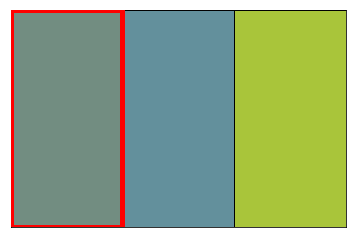

In [150]:
dev_data.display_game(3014)

In [151]:
train_data.data.head()

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,1124-1,1.459877e+12,1,close,distr2,248,92,50,3,1,...,1.459877e+12,speaker,The darker blue one,201.0,0.0,4,16,13.0,3.0,human
1,1124-1,1.459877e+12,2,far,target,249,25,50,1,2,...,1.459877e+12,speaker,purple,201.0,1.0,1,6,6.0,1.0,human
2,1124-1,1.459877e+12,3,close,distr2,291,59,50,3,3,...,1.459877e+12,speaker,Medium pink the medium dark one,201.0,0.0,4,16,13.0,3.0,human
3,1124-1,1.459877e+12,4,split,distr1,85,21,50,2,1,...,1.459877e+12,speaker,lime,201.0,0.0,1,4,4.0,1.0,human
4,1124-1,1.459877e+12,5,far,target,156,84,50,1,3,...,1.459877e+12,speaker,Mint green.,201.0,1.0,2,9,9.0,2.0,human


In [15]:
experiment_fourier.model.load_state_dict(torch.load("../model/literal_listener.params"))

In [17]:
experiment_fourier.evaluate_iter(experiment_fourier.train_pairs[0])

(1, tensor([[-200.0610,    0.0000,  -22.8145]]))

0) Game: 1124-1 Round: 1
The darker blue one


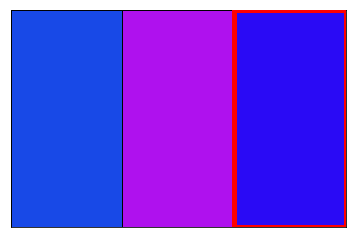

In [21]:
experiment_fourier.train_data.display_game(0)

In [22]:
experiment_fourier.train_pairs[0]

(tensor([[0],
         [1],
         [2],
         [3],
         [4],
         [5]]),
 tensor([[ 1.0000e+00, -9.7832e-01,  9.1421e-01,  9.7832e-01, -1.0000e+00,
           9.7832e-01,  9.1421e-01, -9.7832e-01,  1.0000e+00, -5.5557e-01,
           3.7132e-01, -1.7096e-01, -7.1573e-01,  5.5557e-01, -3.7132e-01,
          -8.4485e-01,  7.1573e-01, -5.5557e-01, -3.8268e-01,  5.6573e-01,
          -7.2425e-01, -1.8304e-01,  3.8268e-01, -5.6573e-01,  2.4541e-02,
           1.8304e-01, -3.8268e-01,  0.0000e+00, -2.0711e-01,  4.0524e-01,
          -2.0711e-01, -1.2246e-16,  2.0711e-01, -4.0524e-01,  2.0711e-01,
           0.0000e+00, -8.3147e-01,  9.2851e-01, -9.8528e-01, -6.9838e-01,
           8.3147e-01, -9.2851e-01, -5.3500e-01,  6.9838e-01, -8.3147e-01,
           9.2388e-01, -8.2459e-01,  6.8954e-01,  9.8311e-01, -9.2388e-01,
           8.2459e-01,  9.9970e-01, -9.8311e-01,  9.2388e-01],
         [ 1.0000e+00, -9.5694e-01,  8.3147e-01,  6.2486e-01, -8.2459e-01,
           9.5331e-01, -2.

In [29]:
experiment_fourier.caption_featurizer.caption_indexer.get_word_from_idx(5)

'<eos>'

In [ ]:
test_pairs = experiment_fourier.get_pairs(experiment_fourier.test_data)
experiment_fourier.model.eval()

In [124]:
test_scores = []
correctness = []
for pair in test_pairs:
    correct, model_output = experiment_fourier.evaluate_iter(pair)
    # the score we care about is the amount of probability mass
    # on the target (let's say)
    target = pair[-1].item()
    pair_score = model_output[0][target].item() # batch size of 1, so first idx is 0
    test_scores.append(pair_score)
    correctness.append(correct)

In [45]:
exp_test_scores = np.exp(test_scores)

In [46]:
exp_test_scores[:40]

array([1.00000000e+00, 9.97000434e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.81215962e-10,
       1.00000000e+00, 1.00000000e+00, 1.57549078e-04, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.30012075e-07, 1.00000000e+00,
       9.99919895e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.99997735e-01, 3.60957279e-13, 1.67209869e-01, 1.00000000e+00,
       4.17024040e-02, 7.63119432e-10, 1.00000000e+00, 1.00000000e+00,
       9.99117823e-01, 9.47232087e-01, 1.00000000e+00, 1.00000000e+00,
       9.99994278e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [40]:
test_pairs[0][-1].item()

0

In [47]:
import pandas as pd

In [49]:
dev_data.data[:1].T

,0
gameid,2641-2
clkTime,1.47649e+12
roundNum,1
condition,split
clickStatus,target
clickColH,48
clickColS,13
clickColL,50
clickLocS,2
clickLocL,1


In [28]:
# we would use experiment_fourier.test_data.data, but use dev_data for compactness
eval_df = dev_data.data[["gameid", "roundNum", 'workerid_uniq', 'condition', 'numOutcome']].copy()

In [55]:
eval_df["model_score"] = exp_test_scores

In [125]:
eval_df["model_correctness"] = correctness

In [126]:
eval_df

,gameid,roundNum,workerid_uniq,condition,numOutcome,model_score,model_correctness
0,2641-2,1,619.0,split,1.0,1.000000e+00,1
1,2641-2,2,619.0,split,1.0,9.970004e-01,1
2,2641-2,3,619.0,far,1.0,1.000000e+00,1
3,2641-2,4,619.0,split,1.0,1.000000e+00,1
4,2641-2,5,619.0,far,1.0,1.000000e+00,1
5,2641-2,6,619.0,close,1.0,1.000000e+00,1
6,2641-2,7,619.0,far,1.0,1.000000e+00,1
7,2641-2,8,619.0,far,1.0,1.000000e+00,1
8,2641-2,9,619.0,close,1.0,1.000000e+00,1
9,2641-2,10,619.0,far,1.0,1.000000e+00,1


In [29]:
true_scores = eval_df.groupby('gameid').numOutcome.mean()

In [59]:
model_scores = eval_df.groupby('gameid').model_score.mean()

In [127]:
model_correctness = eval_df.groupby('gameid').model_correctness.mean()

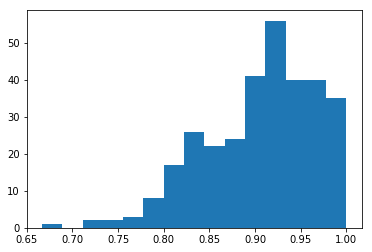

In [68]:
plt.hist(true_scores, 15)
plt.show()

In [32]:
true_scores_rounded = [round_partial(score, 1/50) for score in true_scores]

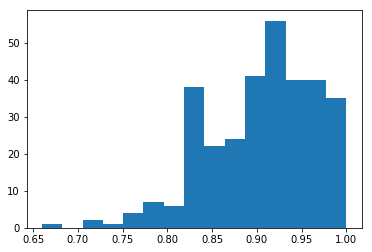

In [33]:
plt.hist(true_scores_rounded, 15)
plt.show()

In [16]:
# random trial:
random_trials = np.random.binomial(50, 0.9, size=10*len(eval_df))

In [40]:
true_scores_type = []
for score in true_scores_rounded:
    true_scores_type.append(int(score*50))

In [42]:
from collections import Counter

In [45]:
true_score_freqs = Counter(true_scores_type)

In [50]:
true_score_freqs

Counter({33: 1,
         36: 2,
         37: 1,
         38: 4,
         39: 7,
         40: 6,
         41: 13,
         42: 25,
         43: 22,
         44: 24,
         45: 41,
         46: 56,
         47: 40,
         48: 40,
         49: 24,
         50: 11})

In [51]:
# get expected value of each bin:
p = 0.9; n = 50
expected = {}
for score in true_score_freqs.keys():
    expected[score] = stats.binom.pmf(score, n, p)

In [52]:
expected

{33: 3.04315085589055e-06,
 36: 0.00021128161656611732,
 37: 0.0007194995591170748,
 38: 0.002215301274123551,
 39: 0.006134680451419148,
 40: 0.015183334117262167,
 41: 0.03332927001350264,
 42: 0.06427787788318479,
 43: 0.10762807459509853,
 44: 0.15410383407934708,
 45: 0.18492460089520898,
 46: 0.18090450087575463,
 47: 0.13856514960695693,
 48: 0.07794289665391496,
 49: 0.028632084485111987,
 50: 0.005153775207320118}

In [61]:
true_score_freqs.items()

dict_items([(47, 40), (48, 40), (39, 7), (44, 24), (46, 56), (50, 11), (43, 22), (49, 24), (42, 25), (45, 41), (41, 13), (40, 6), (33, 1), (37, 1), (36, 2), (38, 4)])

In [68]:
true_score_probs = {}
for k, v in true_score_freqs.items():
    true_score_probs[k] = v/len(true_scores)

In [70]:
true_score_probs.values()

dict_values([0.12618296529968454, 0.12618296529968454, 0.022082018927444796, 0.07570977917981073, 0.17665615141955837, 0.03470031545741325, 0.0694006309148265, 0.07570977917981073, 0.07886435331230283, 0.12933753943217666, 0.04100946372239748, 0.01892744479495268, 0.0031545741324921135, 0.0031545741324921135, 0.006309148264984227, 0.012618296529968454])

In [71]:
expected_ = []
observed_ = []
for k in expected:
    expected_.append(expected[k])
    observed_.append(true_score_probs[k])

In [76]:
stats.chisquare(observed_, expected_, ddof=1)

Power_divergenceResult(statistic=3.8923416139845073, pvalue=0.9960796712651203)

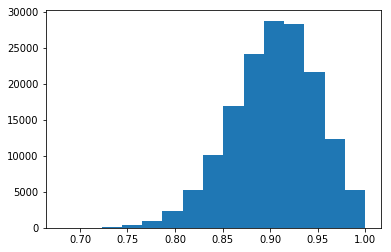

In [20]:
plt.hist(random_trials/50, 15)
plt.show()

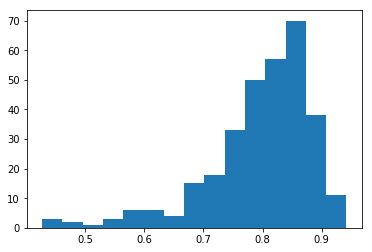

In [65]:
plt.hist(model_scores, 15)
plt.show()

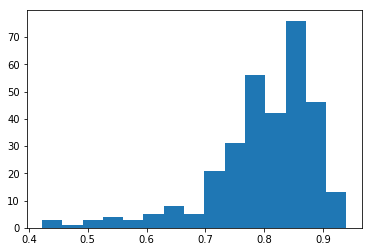

In [128]:
plt.hist(model_correctness, 15)
plt.show()

In [88]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [71]:
len(model_scores)

317

In [87]:
r2_score(true_scores.values, model_scores.values)

-4.751885792701781

In [89]:
mean_squared_error(true_scores.values, model_scores.values)

0.01986950922559723

In [85]:
model_scores.values

array([0.77744075, 0.67065403, 0.71039537, 0.85327866, 0.90100347,
       0.83773925, 0.86608371, 0.87222834, 0.88084828, 0.76591705,
       0.86842579, 0.73347648, 0.82680585, 0.56107105, 0.65463801,
       0.81913266, 0.89708639, 0.9309526 , 0.83143891, 0.68552647,
       0.58046653, 0.85997632, 0.59124963, 0.83466305, 0.8560654 ,
       0.86844101, 0.86598057, 0.68327794, 0.86133539, 0.86189389,
       0.87264596, 0.86913681, 0.89721951, 0.78823099, 0.70885823,
       0.8862998 , 0.79034189, 0.79950135, 0.91886516, 0.8227728 ,
       0.80432691, 0.56830091, 0.77595649, 0.79450527, 0.87693091,
       0.87926259, 0.82108839, 0.7180523 , 0.83838785, 0.44609716,
       0.88544944, 0.81981286, 0.90810139, 0.76166747, 0.75613028,
       0.79846121, 0.75598978, 0.72395044, 0.8415276 , 0.82674672,
       0.84846607, 0.83458866, 0.81889846, 0.89306887, 0.82040098,
       0.84361071, 0.81000648, 0.62673514, 0.72487439, 0.81540657,
       0.74569097, 0.85985182, 0.49384783, 0.76400234, 0.90034

In [86]:
model_scores

gameid
0022-7    0.777441
0069-8    0.670654
0070-1    0.710395
0106-1    0.853279
0109-c    0.901003
0137-f    0.837739
0197-6    0.866084
0217-e    0.872228
0219-7    0.880848
0239-7    0.765917
0255-b    0.868426
0265-e    0.733476
0283-7    0.826806
0315-b    0.561071
0322-8    0.654638
0375-6    0.819133
0389-5    0.897086
0392-6    0.930953
0398-f    0.831439
0415-a    0.685526
0433-7    0.580467
0479-6    0.859976
0519-9    0.591250
0529-2    0.834663
0580-7    0.856065
0699-d    0.868441
0713-f    0.865981
0716-6    0.683278
0736-7    0.861335
0762-d    0.861894
            ...   
8767-6    0.796902
8792-7    0.844681
8794-6    0.817516
8814-1    0.780128
8891-9    0.584855
8958-0    0.881801
8970-0    0.900277
8972-7    0.772187
8978-9    0.826002
9038-b    0.817610
9086-a    0.806429
9260-e    0.768678
9272-8    0.898212
9288-a    0.699363
9307-f    0.789101
9444-5    0.801921
9487-1    0.901880
9601-f    0.771282
9629-5    0.916816
9645-7    0.843261
9709-7    0.843577
9714-

In [77]:
plt.scatter(true_scores.values, model_scores.values)

NameError: name 'model_scores' is not defined

In [26]:
true_scores

NameError: name 'true_scores' is not defined

In [22]:
# from https://stackoverflow.com/questions/8118982/rounding-numbers-to-a-specific-resolution
def round_partial(value, res):
    return round(value/res) * res

In [25]:
round_partial(0.505, 0.02)

0.5

In [108]:
from scipy.stats import pearsonr, chisquare, spearmanr, linregress

In [92]:
pearsonr(true_scores.values, model_scores.values)

(0.299612635637788, 5.363214905877284e-08)

In [97]:
pearsonr(true_scores.values, 3*model_scores.values)

(0.29961263563778795, 5.363214905877496e-08)

In [93]:
spearmanr(true_scores.values, model_scores.values)

SpearmanrResult(correlation=0.2708674906055539, pvalue=9.809317196395298e-07)

In [ ]:
chisquare()

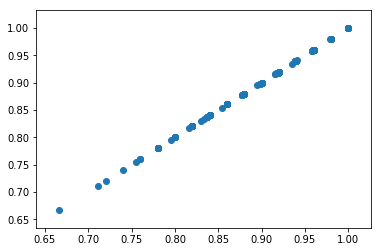

In [94]:
plt.scatter(true_scores.values, true_scores.values)

In [96]:
pearsonr(true_scores.values, true_scores.values)

(1.0, 0.0)

In [102]:
true_scores_neg = np.array([2*score - 1 for score in true_scores.values])

(array([ 1.,  0.,  2.,  2.,  3.,  8., 17., 26., 22., 24., 41., 56., 40.,
        40., 35.]),
 array([0.33333333, 0.37777778, 0.42222222, 0.46666667, 0.51111111,
        0.55555556, 0.6       , 0.64444444, 0.68888889, 0.73333333,
        0.77777778, 0.82222222, 0.86666667, 0.91111111, 0.95555556,
        1.        ]),
 <a list of 15 Patch objects>)

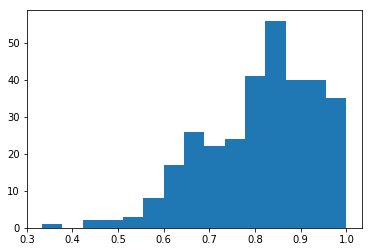

In [104]:
plt.hist(true_scores_neg, 15)

In [107]:
pearsonr(model_scores.values, true_scores_neg)

(0.29961263563778795, 5.363214905877496e-08)

In [121]:
pearsonr(true_scores.values, model_scores.values)

(0.299612635637788, 5.363214905877284e-08)

In [112]:
result = linregress(model_scores.values, true_scores.values)

In [122]:
a = np.linspace(0.4, 1, 100)

<function matplotlib.pyplot.show>

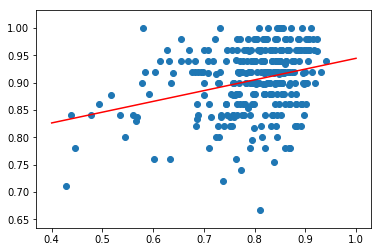

In [123]:
plt.scatter(model_scores.values, true_scores.values)
plt.plot(a, result.slope*a+result.intercept, color="red")
plt.show()

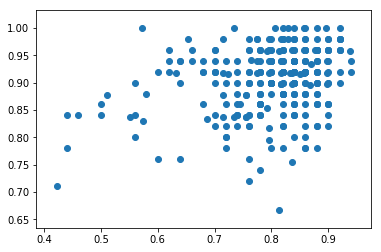

In [129]:
plt.scatter(model_correctness.values, true_scores.values)
plt.show()

In [130]:
pearsonr(model_correctness, true_scores)

(0.29061789237459024, 1.379199466945515e-07)

In [131]:
spearmanr(model_correctness, true_scores)

SpearmanrResult(correlation=0.25647779273541804, pvalue=3.7274518200042415e-06)